In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [29]:
!pip install spacy
!python -m spacy download en_core_web_sm

  Using cached wasabi-0.9.1-py3-none-any.whl (26 kB)
  Using cached murmurhash-1.0.7-cp39-cp39-win_amd64.whl (18 kB)
  Using cached pathy-0.6.1-py3-none-any.whl (42 kB)
  Using cached cymem-2.0.6-cp39-cp39-win_amd64.whl (36 kB)
  Using cached langcodes-3.3.0-py3-none-any.whl (181 kB)
  Using cached preshed-3.0.6-cp39-cp39-win_amd64.whl (112 kB)
  Using cached smart_open-5.2.1-py3-none-any.whl (58 kB)


2022-04-28 08:51:42.446449: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-04-28 08:51:42.447435: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [25]:
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to c:\users\vitor\appdata\local\temp\pip-req-build-3k42lydj
  Resolved https://github.com/laxmimerit/preprocess_kgptalkie.git to commit 9ca68d37027af9f6a30d54640347ce3b2e2694b3
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-py3-none-any.whl size=7692 sha256=9e2d64a7d4a3138641ca882ac1c3769074d540e131d46e5df23efb50fd57ae66
  Stored in directory: C:\Users\vitor\AppData\Local\Temp\pip-ephem-wheel-cache-o2i7ihew\wheels\d1\c3\bb\559fe93e652b51cbc532f17e9693f3b70055f8560cf06c1fb3
Successfully built preprocess-kgptalkie
  Attempting uninstall: preprocess-kgptalkie
    Found existing installation: preprocess-kgptalkie 0.1.3
    Uninstalling preprocess-kgptalkie-0.1.3:
      Successfully uninstalled preprocess-kgptalkie-0.1.3


  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git 'C:\Users\vitor\AppData\Local\Temp\pip-req-build-3k42lydj'


In [37]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.Collecting gensim
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.24
    Uninstalling Cython-0.29.24:
      Successfully uninstalled Cython-0.29.24



Importação do Corpus Português-Br

In [13]:
true=[]
for i in range(1,3601):
  with open(r'C:\Users\vitor\Documents\TCC.v3\Software\Fake.br-Corpus\full_texts\true\\'+str(i)+'.txt', encoding ="utf8") as t:
    true.append(t.read())

In [14]:
df_true = pd.DataFrame(true, columns = ['texto'])

In [15]:
print(df_true)

                                                  texto
0     ﻿O Podemos decidiu  expulsar o deputado federa...
1     Em evento realizado nesta terça-feira para div...
2     ﻿Após o prefeito de Manaus Arthur Virgílio (PS...
3     ﻿Doria vai receber Zé Celso após reunião com r...
4     Gustavo Pedreira Ferraz, que admitiu buscar ma...
...                                                 ...
3595  Ficou longe das notícias no fim de ano? Veja o...
3596   A nova denúncia contra o ex-presidente Luiz I...
3597  Como a Bahia virou uma potência mundial do mar...
3598  Alvo da Lava Jato, Bendine tinha passagem comp...
3599  Chefs convidados do Encontro Mundial das Cidad...

[3600 rows x 1 columns]


In [16]:
fake=[]
for i in range(1,3601):
  with open(r'C:\Users\vitor\Documents\TCC.v3\Software\Fake.br-Corpus\full_texts\fake\\'+str(i)+'.txt', encoding ="utf8") as t:
    fake.append(t.read())

In [17]:
df_fake = pd.DataFrame(fake, columns = ['texto'])

In [18]:
print(df_fake)

                                                  texto
0     Kátia Abreu diz que vai colocar sua expulsão e...
1     Blog esquerdista dá a entender que reclamar de...
2     Alckmin diz que por ele PSDB desembarca, mas...
3     Cara de pau não tem limites: Zé Celso aciona M...
4     Temer resolve o problema de Luislinda: liberd...
...                                                 ...
3595  Grupo de 100 mil pessoas quer criar novo país ...
3596  Montadoras pagaram R$ 36 milhões para aprovar ...
3597  Deputado do PT não sabia que estava sendo film...
3598  Cunha cancelou a viagem à Itália porque poderi...
3599  Mulher bêbada invade Planalto e diz que é "mar...

[3600 rows x 1 columns]


Preprocessing

In [19]:
df_true['texto'] = df_true['texto'].apply(lambda x: str(x).lower())
df_fake['texto'] = df_fake['texto'].apply(lambda x: str(x).lower())

In [20]:
df_true['class'] = 1
df_fake['class'] = 0

In [21]:
df_true.columns

Index(['texto', 'class'], dtype='object')

In [22]:
data = df_true.append(df_fake, ignore_index=True)

In [30]:
import preprocess_kgptalkie as ps

In [31]:
#Método antido de remover caracteres especiais
#data['texto'].apply(lambda x: ps.remove_special_chars(x))

In [34]:
#Removes punctuation from every text within the DataFrame

def remove_punct(raw_string):
  '''Eliminates punctuations and numbers from raw_string.'''
  translator = raw_string.maketrans({key:'' for key in string.punctuation.replace("-", '') + "“”‘’0123456789"})

  return raw_string.translate(translator)

data['texto'] = data['texto'].apply(func=remove_punct)

In [35]:
print(data['texto'][0])

﻿o podemos decidiu  expulsar o deputado federal carlos gaguim do partido após a polícia federal fazer buscas a apreensões no gabinete dele na câmara com isso a legenda abre espaço para receber a senadora expulsa pelo pmdb katia abreu por meio de nota a legenda informou que o afastamento do parlamentar já era algo acordado entre os filiados da sigla  ainda que o parlamentar tenha comunicado a conclusão de sua desfiliação para esta semana diante dos fatos noticiados hoje a executiva nacional do podemos solicita o imediato cancelamento de sua filiação dos quadros do partido

o partido que no passado chegou a cogitar lançar o parlamentar como candidato ao senado diz que apoia a investigação com a ampla apuração dos eventuais crimes cometidos e a consequente responsabilização dos envolvidos para que todos sejam punidos com o máximo rigor da lei independentemente de posição ou cargo ocupado 


Vectorization - Word2Vec

In [38]:
import gensim

In [39]:
y = data['class'].values

In [40]:
X = [d.split() for d in data['texto'].tolist()]

In [47]:
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=DIM, window=10, min_count=1)

In [48]:
w2v_model.wv.most_similar('bolsonaro')

[('jair', 0.8567922711372375),
 ('ciro', 0.785841166973114),
 ('alckmin', 0.758470356464386),
 ('presidenciável', 0.7401278614997864),
 ('psc-rj', 0.7190741300582886),
 ('boulos', 0.6930719614028931),
 ('pré-candidato', 0.6814339756965637),
 ('psl', 0.678733229637146),
 ('eleitorado', 0.6628262400627136),
 ('marina', 0.6536750793457031)]

In [49]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [50]:
X = tokenizer.texts_to_sequences(X)

In [51]:
#tokenizer.word_index - coloca as palavras em ordem de aparecimento

Analisando tamanho dos textos

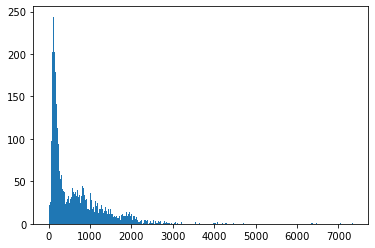

In [52]:
plt.hist([len(x) for x in X], bins = 700)
plt.show()

In [53]:
#verificando quantas notícias tem mais do que o número de palavras especificado
nos = np.array([len(x) for x in X])
len(nos[nos>2000])

311

In [54]:
maxlen = 2000
X = pad_sequences(X, maxlen=maxlen)

In [55]:
vocab_size = len(tokenizer.word_index) + 1 #verificar novamente em 1h09 o pq do "+1"
vocab = tokenizer.word_index

In [56]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size, DIM))

  for word, i in vocab.items():
    weight_matrix[i] = model.wv[word]

  return weight_matrix

In [57]:
embedding_vectors = get_weight_matrix(w2v_model)

Criando o modelo de rede neural

In [58]:
#colocar trainable = True pra ver se melhora o resultado se a ML ficar retrinando
model = Sequential()
model.add(Embedding(vocab_size, output_dim=DIM, weights = [embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 100)         8998800   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9,116,177
Trainable params: 117,377
Non-trainable params: 8,998,800
_________________________________________________________________


Treinando o modelo

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [61]:
model.fit(X_train, y_train, validation_split=0.1, epochs=6)

Epoch 1/6
152/152 [==============================] - 436s 3s/step - loss: 0.6141 - acc: 0.6636 - val_loss: 0.6215 - val_acc: 0.6167
Epoch 2/6
152/152 [==============================] - 416s 3s/step - loss: 0.5332 - acc: 0.7247 - val_loss: 0.5506 - val_acc: 0.6926
Epoch 3/6
152/152 [==============================] - 410s 3s/step - loss: 0.5100 - acc: 0.7496 - val_loss: 0.5005 - val_acc: 0.7352
Epoch 4/6
152/152 [==============================] - 411s 3s/step - loss: 0.5020 - acc: 0.7558 - val_loss: 0.5537 - val_acc: 0.7111
Epoch 5/6
152/152 [==============================] - 565s 4s/step - loss: 0.4787 - acc: 0.7687 - val_loss: 0.4535 - val_acc: 0.8185
Epoch 6/6
152/152 [==============================] - 438s 3s/step - loss: 0.2286 - acc: 0.9272 - val_loss: 0.2688 - val_acc: 0.8981


In [62]:
y_pred = (model.predict(X_test) >=0.5).astype(int)

In [63]:
accuracy_score(y_test, y_pred)

0.8988888888888888

Testando o modelo com novas notícias

In [114]:
df_true['texto'][4]

'gustavo pedreira ferraz, que admitiu buscar malas de dinheiro para geddel vieira lima, afirmou à pf ter trabalhado na campanha presidencial de 2014 para o então candidato aécio neves (psdb). ex-diretor da defesa civil de salvador, bahia, ele resolveu colaborar com investigações sobre o bunker dos r$ 51 milhões. as digitais de ferraz foram encontradas nas cédulas de r$ 50 e r$ 100 que rechearam as malas e caixas de dinheiro encontradas na maior apreensão da história da pf. por meio de sua assessoria, o senador nega que gustavo tenha trabalhado em sua campanha.\nconselheiro de ética do pmdb na bahia, ferraz admitiu que, em 2012, buscou uma mala de dinheiro para em um hotel em são paulo para o ex-ministro. ele afirma que ainda voltou a salvador em voo fretado e foi levado por um motorista do pmdb até a casa de geddel, aonde o dinheiro da mala foi contado. ferraz se diz traído já que esperava que o ex-ministro repassasse o montante para as campanhas de candidatos baianos às prefeituras e,

Testando notícia True dentro do Corpus

In [38]:
#sentence_t = df_true['texto'][0]

In [64]:
sentence_t = ["em evento realizado nesta terça-feira para divulgar o jogo das estrelasum amistoso beneficente que será realizado nesta quarta, no estádio do maracanã, no rio de janeiro, zico foi questionado sobre o ano do flamengo. e o ídolo do clube não poupou críticas à montagem do elenco.\n\n minha visão é que alguns investimentos que foram feito não surtiram efeito dentro do campo. acho que é uma equipe supervalorizada, falei isso muito tempo antes, reclamou. não é fácil você trazer muita gente, ainda mais no meio de competição, com mudanças constantes, lesões. a coisa não funcionou.\n\nna avaliação de zico, faltou um trabalho melhor de avaliação dos jogadores contratados, especialmente os que vieram do futebol exterior. o futebol é isso mesmo, precisa seguir em frente e analisar quando vocês faz os investimentos, principalmente quando você vai atrás de jogadores que estão no exterior. é preciso saber como eles estão, o rendimento, questões de saúde, alertou. e infelizmente não foi isso que aconteceu com alguns jogadores que o flamengo investiu.\n\nzico avaliou também que a diretoria precisa se preocupar em trazer jogadores identificados com o clube. na reta final da temporada, muito se criticou a suposta falta de garra de alguns atletas. precisa saber também o que representa a camisa do flamengo, a história do clube, disse. é preciso ser bem entendido que o flamengo é um clube muito diferente dos outros.\n\no resultado, assim, segundo ele, é que o ano termina de maneira frustrante ao torcedor. é lógico que o objetivo principal era ter uma boa atuação na libertadores, o que não aconteceu. consequentemente conseguiu chegar na sul-americana, chegou a duas finais. mas ficou um gostinho amargo de não ter conquistado uma competição internacional"]

In [144]:
sentence_t = ["lógico que pelo investimento era esperado que isto acontecesse"]

In [154]:
sentence_t = ["as digitais de ferraz foram encontradas nas cédulas de r$ 50 e r$ 100 que rechearam as malas e caixas de dinheiro encontradas na maior apreensão da história da pf. por meio de sua assessoria, o senador nega que gustavo tenha trabalhado em sua campanha.\nconselheiro de ética do pmdb na bahia, ferraz admitiu que, em 2012, buscou uma mala de dinheiro para em um hotel em são paulo para o ex-ministro. ele afirma que ainda voltou a salvador em voo fretado e foi levado por um motorista do pmdb até a casa de geddel, aonde o dinheiro da mala foi contado. ferraz se diz traído já que esperava que o ex-ministro repassasse o montante para as campanhas de candidatos baianos às prefeituras e, na verdade, foram parar no bunker.\nele afirma à pf que também colaborou para a campanha de geddel ao governo estadual, em 2010. à época das eleições de 2012, ele alega ter sido assessor de bancada do pmdb na assembleia legislativa do estado da bahia.\nferraz assumiu em 2013, a superintendência da indústria e comércio de salvador, função que exerceu até o fim de 2014.\nnaquele ano, ele diz ter feito campanha política para geddel, então candidato ao senado, paulo souto, candidato ao governo do estado da bahia, e aécio neves, candidato a presidente.\nferraz foi preso na operação tesouro perdido, após serem encontradas suas digitais nas notas do bunker dos r$ 51 milhões. ele pagou fiança para deixar a cadeia. o valor, estipulado pelo supremo, foi de 50 salários mínimos.\ncom a palavra, aécio neves\n“o sr gustavo ferraz não trabalhou na campanha presidencial do psdb em 2014”.\ncom a palavra, souto\na reportagem não localizou paulo souto. o espaço está aberto para manifestação. gustavo pedreira ferraz, que admitiu buscar malas de dinheiro para geddel vieira lima, afirmou à pf ter trabalhado na campanha presidencial de 2014 para o então candidato aécio neves (psdb). ex-diretor da defesa civil de salvador, bahia, ele resolveu colaborar com investigações sobre o bunker dos r$ 51 milhões. "]

['as digitais de ferraz foram encontradas nas cédulas de r$ 50 e r$ 100 que rechearam as malas e caixas de dinheiro encontradas na maior apreensão da história da pf. por meio de sua assessoria, o senador nega que gustavo tenha trabalhado em sua campanha.\nconselheiro de ética do pmdb na bahia, ferraz admitiu que, em 2012, buscou uma mala de dinheiro para em um hotel em são paulo para o ex-ministro. ele afirma que ainda voltou a salvador em voo fretado e foi levado por um motorista do pmdb até a casa de geddel, aonde o dinheiro da mala foi contado. ferraz se diz traído já que esperava que o ex-ministro repassasse o montante para as campanhas de candidatos baianos às prefeituras e, na verdade, foram parar no bunker.\nele afirma à pf que também colaborou para a campanha de geddel ao governo estadual, em 2010. à época das eleições de 2012, ele alega ter sido assessor de bancada do pmdb na assembleia legislativa do estado da bahia.\nferraz assumiu em 2013, a superintendência da indústria e 

In [65]:
sequences_t = tokenizer.texts_to_sequences(sentence_t)
padded_t = pad_sequences(sequences_t, maxlen=maxlen)

In [66]:
model.predict(padded_t)

array([[0.906942]], dtype=float32)

In [67]:
(model.predict(padded_t) >=0.5).astype(int)

array([[1]])

Testando notícia True fora do Corpus

In [72]:
sentence_t = ["a vantagem de lula sobre o presidente caiu pontos na última pesquisa de intenção de voto mesmo com toda a mídia negativa de quem é vidraça bolsonaro consegue se manter em crescimento o ex-presidente lula ainda não conseguiu organizar sua campanha nem fazer coligações que o garanta nos estados bolsonaro foi beneficiado pela janela partidária onde o pl seu partido saiu como o maior do país e o centrão que o apoia como a grande base do congresso"]

In [71]:
sentence_t = ["O médico Glauto Tuquarre Melo que morreu aos 49 anos por suspeita de infarto durante um voo que o levaria para a lua de mel nas Maldivas na madrugada de ontem era querido pelos colegas de trabalho cursava o primeiro ano do doutorado na UFPI e era pesquisador da depressão em pacientes com câncer Familiares seguem aguardando o traslado do corpo do profissional de saúde de Doha no Catar para o Brasil que deve levar ao menos três dias para ser liberado antes de seguir para o território brasileiro e ainda não divulgou informações sobre o velório"]

In [109]:
sentence_t = ["Já se passaram quase dias desde a substituição do Cartão Nutrir Emergencial que beneficia mil famílias carentes de Campinas com por mês e mil delas ainda não retiraram o dispositivo O balanço contabilizado até esta segunda-feira pela prefeitura representa uma quantia de de créditos de abril represados O programa Nutrir Emergencial foi criado no início da pandemia em para ajudar as famílias mais vulneráveis da metrópole a comprar itens básicos durante o período de crise financeira A Secretaria Municipal de Assistência Social Pessoa com Deficiência e Direitos Humanos alertou que o benefício tem um prazo máximo de três meses para ser utilizado pelos moradores sob risco do valor voltar para a prefeitura Neste caso o valor é usado em créditos futuros e a família que não manifestou interesse pelo benefício pode ser desligada do programa O crédito é bloqueado até darmos baixa no cartão disse a Pasta Em nota a prefeitura informou que está mantendo esforços para localizar as famílias com contatos por SMS nos telefones celulares do cadastro A maior parte dos cartões foi entregue na Estação Cultura no fim de março e o restante foi direcionado para pontos descentralizados da metrópole"]

In [73]:
sequences_t = tokenizer.texts_to_sequences(sentence_t)
padded_t = pad_sequences(sequences_t, maxlen=maxlen)

In [74]:
model.predict(padded_t)

array([[0.12879694]], dtype=float32)

In [75]:
(model.predict(padded_t) >=0.5).astype(int)

array([[0]])

Testando notícias falsas

In [54]:
from pandas._libs.algos import pad
x = ["Bolsonaro mostra quem manda e sanciona lei que todos os brasileiros queriam"]
x = tokenizer.texts_to_sequences(x)
pad_sequences(x, maxlen=maxlen)

array([[   0,    0,    0, ...,   17,  731, 3431]], dtype=int32)

In [59]:
sentence_f = ["Bolsonaro mostra quem manda e sanciona lei que todos os brasileiros queriam. Agora todo cidadão de bem pode comprar sua arma favorita e ter em casa pistolas, metralhadoras e fuzis. O projeto de lei já foi aprovado pela câmara e pelo senado e foi sem maiores problemas"]

In [60]:
sequences_f = tokenizer.texts_to_sequences(sentence_f)
padded_f = pad_sequences(sequences_f, maxlen=maxlen)

In [62]:
model.predict(padded_f)

array([[0.0307194]], dtype=float32)

In [63]:
(model.predict(padded_f) >=0.5).astype(int)

array([[0]])